# OCR System comparison for Invoices

In the following notebook the following OCR systems will be used on different invoices to determine their effectiveness:
1. Tesseract
2. Google Vision
3. Microsoft Azure Form-Recogniser

The code used bellow is based on each systems respective documentation

### Terminal Command
export GOOGLE_APPLICATION_CREDENTIALS="/Users/achilleasdrakou/Documents/Education/CASS/Semester 3/ARP/invoice-recognition-project.json"

In [3]:
#Import packages
import pytesseract as pts #Tesseract
from google.cloud import vision #Google Vision
from azure.core.credentials import AzureKeyCredential #Azure credentcials
from azure.ai.formrecognizer import FormRecognizerClient #Azure Form Recognizer
from azure.identity import DefaultAzureCredential #Azure Form Credencials
import requests #For Azure pull requests 


#coverting pdfs to images
import io
from pdf2image import convert_from_path
import os
# from IPython.display import display, Image

#Plotting bounding boxes
import cv2 #used for tesseract
from google.cloud.vision import types #used for gvision
from PIL import Image, ImageDraw
from enum import Enum

import sys
from matplotlib.patches import Rectangle
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tesserocr import PyTessBaseAPI, RIL


#Calculating Levenshtein Distance
from Levenshtein import distance as lev_distance
from difflib import ndiff


In [4]:
# Levenshtein Distance Calculation
def str_distance(str_1, str_2):
    distance = 0
    buffer_removed = buffer_added = 0
    for x in ndiff(str_1, str_2):
        code = x[0]
        # Code ? is ignored as it does not translate to any modification
        if code == ' ':
            distance += max(buffer_removed, buffer_added)
            buffer_removed = buffer_added = 0
        elif code == '-':
            buffer_removed += 1
        elif code == '+':
            buffer_added += 1
    distance += max(buffer_removed, buffer_added)
    return distance

# Invoice Information

In [5]:
# Converting pdf to images
invoice = '../invoices/invoice3.pdf'
pages = convert_from_path(invoice, 501)
for page in pages:
    page.save('../invoices/invoice3.jpg')
    with io.open('../invoices/invoice3.jpg', 'rb') as image_file:
        content = image_file.read()
        
jpg = '../invoices/invoice3.jpg'
# display(Image(jpg))

In [6]:
# Copy pasted text from inovoice 1 pdf
invoice_txt = "АСМЕ Acme, Inc. Invoice Number #000016 555-555-1234 x137 Issue Date 2018-05-14 Due Date 2018-05-14 Bill to: Ship to: PAID $379.25 Marty McFly 200 Billing Rd. Marty McFly 100 Shipping St. Apt 200 Pleasantville, NC 12345 Suite 100 Needham, MA 02494 Item Quantity Unit Price Amount Professional Plan1 1 $99.00 $99.00 05/14/2018 - 06/14/2018 Small Instance (Hourly)' 1 353 $0.25 $88.25 Large Instance (Hourly)’ 415 $0.50 $207.50 Subtotal $394.75 Discount(s) Applied: Discounts ($39.48) 1. MULTI3 - Multi-service discount (10%) $39.48 NC Sales Tax (6.75%) $23.98 Total $379.25 Paid $379.25 Due $0.00 Payment History 05/14/2018 06:26AM EDT Prepayment applied: $50.00 (From Check: 05/14/2018 - $50.00 - Check #45678) 05/14/2018 06:27AM EDT Credit card payment: $329.25 (Visa, XXXX-XXXX-XXXX-1111)"

keywords = ["Invoice Number #000016",
            "555-555-1234 x137",
            "Issue Date 2018-05-14",
            "Due Date 2018-05-14",
            "PAID $379.25",
            "Professional Plan1 1 $99.00 $99.00",
            "05/14/2018 - 06/14/2018",
            "Small Instance (Hourly)1 353 $0.25 $88.25",
            "Large Instance (Hourly)1 415 $0.50 $207.50",
            "Subtotal $394.75",
            "Discounts ($39.48)",
            "1. MULTI3 - Multi-service discount (10%) $39.48 NC Sales Tax (6.75%) $23.98",
            "Total $379.25",
            "Paid $379.25",
            "Due $0.00",
            "05/14/2018 06:26AM EDT Prepayment applied: $50.00 (From Check: 05/14/2018 - $50.00 - Check #45678)",
            "05/14/2018 06:27AM EDT Credit card payment: $329.25 (Visa, XXXX-XXXX-XXXX-1111)"
           ]

In [7]:
# Number of edits required for key word pairings to be corrected
# in comparison to the original text
base_key = str_distance(invoice_txt, keywords)
base_key

789

## Tesseract

### Text Extraction

In [5]:
page = jpg
for page in pages:
    test_str = pts.image_to_data(page, lang='eng', config='--psm 6')
    current_linenum = 0
    current_line = ''
    for _line in test_str.split('\n')[1:]:
        line = _line.split('\t')
        if line[4] == current_linenum:
            current_line += line[-1] + ' '
        else:
            print(current_line)
            current_linenum = line[4]
            current_line = line[-1]
    print(current_line)


  
Acme, Inc. Invoice Number #000016 
555-555-1234 x137 
issue Date 2018-05-14 
Due Date 2018-05-14 
Bill to: Ship to: 
Marty McFly Marty McFly PAID $379.25 
200 Billing Rd. 100 Shipping St. 
Suite 100 Apt 200 
Needham, MA 02494 Pleasantville, NC 12345 
Item Quantity Unit Price Amount 
Professional Plan! 1 $99.00 $99.00 
05/14/2018 - 06/14/2018 
Small Instance (Hourly)! 353 $0.25 $88.25 
Large Instance (Hourly)' 415 $0.50 $207.50 
Subtotal $394.75 
Discount(s) Applied: 
Discounts ($39.48) 
1. MULTI3 - Multi-service discount (10%) $39.48 NC Sales Tax (6.75%) $23.98 
Total $379.25 
Paid $379.25 
Due $0.00 
Payment History 
05/14/2018 06:26AM EDT Prepayment applied: $50.00 (From Check: 05/14/2018 - $50.00 - Check #45678) 


IndexError: list index out of range

In [34]:
# Extracting text to varyiable
tes_txt = "Acme, Inc. Invoice Number #000016  555-555-1234 x137  issue Date 2018-05-14  Due Date 2018-05-14  Bill to: Ship to:  Marty McFly Marty McFly PAID $379.25  200 Billing Rd. 100 Shipping St.  Suite 100 Apt 200  Needham, MA 02494 Pleasantville, NC 12345  Item Quantity Unit Price Amount Professional Plan! 1 $99.00 $99.00  05/14/2018 - 06/14/2018  Small Instance (Hourly)! 353 $0.25 $88.25  Large Instance (Hourly)' 415 $0.50 $207.50  Subtotal $394.75  Discount(s) Applied:  Discounts ($39.48)  1. MULTI3 - Multi-service discount (10%) $39.48 NC Sales Tax (6.75%) $23.98  Total $379.25  Paid $379.25  Due $0.00  Payment History  05/14/2018 06:26AM EDT Prepayment applied: $50.00 (From Check: 05/14/2018 - $50.00 - Check #45678) 05/14/2018 06:27AM EDT Credit card payment: $329.25 (Visa, XXXX-XXXX-XXXX-1111)"

### Plotting bounding boxes 

In [70]:
# read the image and get the dimensions
img = cv2.imread(jpg)
h, w, _ = img.shape # assumes color image

# run tesseract, returning the bounding boxes
boxes = pts.image_to_boxes(img) # also include any config options you use

# draw the bounding boxes on the image
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# show annotated image and wait for keypress
cv2.imshow(jpg, img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('../Outputs/tesseract - invoice3.jpg', img) 

True

### Confidence Levels

In [38]:
image = Image.open(jpg)
with PyTessBaseAPI() as api:
    api.SetImage(image)
    boxes = api.GetComponentImages(RIL.TEXTLINE, True)
    print('{}'.format(len(boxes)))
    for i, (im, box, _, _) in enumerate(boxes):
        # im is a PIL image object
        # box is a dict with x, y, w and h keys
        api.SetRectangle(box['x'], box['y'], box['w'], box['h'])
        ocrResult = api.GetUTF8Text()
        conf = api.MeanTextConf()
#         inspectling confidence levels for each text block
#         print((u"Box[{0}]:""confidence: {1}, text: {2}").format(i, conf, ocrResult, **box)) 
        sys.stdout.write((u"{0}").format( conf, **box) + ',')

31
0,0,95,96,95,93,95,95,78,0,82,89,91,92,93,0,0,0,94,0,0,0,0,96,96,95,95,0,96,94,93,

In [39]:
tes_conf = (0,0,95,96,95,93,95,95,78,0,82,89,91,92,93,0,0,0,94,0,0,0,0,96,96,95,95,0,96,94,93)
tes_conf =list(filter(lambda a: a != 0,tes_conf)) #remove 0 values
tes_conf_average = sum(tes_conf)/len(tes_conf)
tes_conf_average

92.65

### Levenshtein Distance Score

In [44]:
lev_distance(invoice_txt, tes_txt)

188

### Key word pairings

In [45]:
# Number of key edits required for key word pairings to be correct
tes_key = str_distance(tes_txt, keywords)
print(tes_key - base_key)

14


## Google Vision API
### Text Extraction

In [46]:
pages = convert_from_path(invoice, 501)
client = vision.ImageAnnotatorClient()

for page in pages:
    page.save('tmp.jpg')
    with io.open('tmp.jpg', 'rb') as image_file:
        content = image_file.read()
    os.system('rm tmp.jpg')
    image = vision.types.Image(content = content)
    response = client.text_detection(image = image)
    print(response.text_annotations[0].description)

АСМЕ
Acme, Inc.
Invoice Number
#000016
555-555-1234 x137
Issue Date
2018-05-14
Due Date
2018-05-14
Bill to:
Ship to:
PAID
$379.25
Marty McFly
200 Billing Rd.
Marty McFly
100 Shipping St.
Apt 200
Pleasantville, NC 12345
Suite 100
Needham, MA 02494
Item
Quantity
Unit Price
Amount
Professional Plan1
1
$99.00
$99.00
05/14/2018 - 06/14/2018
Small Instance (Hourly)'
1
353
$0.25
$88.25
Large Instance (Hourly)"
415
$0.50
$207.50
Subtotal
$394.75
Discount(s) Applied:
Discounts
($39.48)
1. MULTI3 - Multi-service discount (10%)
$39.48
NC Sales Tax (6.75%)
$23.98
Total
$379.25
Paid
$379.25
Due
$0.00
Payment History
05/14/2018 06:26AM EDT Prepayment applied: $50.00 (From Check: 05/14/2018 - $50.00 - Check #45678)
05/14/2018 06:27AM EDT Credit card payment: $329.25 (Visa, XXXX-XXXX-XXXX-1111)



In [1]:
# Extracting text to varyiable
gvision_txt = "АСМЕ Acme, Inc. Invoice Number #000016 555-555-1234 x137 Issue Date 2018-05-14 Due Date 2018-05-14 Bill to: Ship to: PAID $379.25 Marty McFly 200 Billing Rd. Marty McFly 100 Shipping St. Apt 200 Pleasantville, NC 12345 Suite 100 Needham, MA 02494 Item Quantity Unit Price Amount Professional Plan1 1 $99.00 $99.00 05/14/2018 - 06/14/2018 Small Instance (Hourly)' 1 353 $0.25 $88.25 Large Instance (Hourly)’ 415 $0.50 $207.50 Subtotal $394.75 Discount(s) Applied: Discounts ($39.48) 1. MULTI3 - Multi-service discount (10%) $39.48 NC Sales Tax (6.75%) $23.98 Total $379.25 Paid $379.25 Due $0.00 Payment History 05/14/2018 06:26AM EDT Prepayment applied: $50.00 (From Check: 05/14/2018 - $50.00 - Check #45678) 05/14/2018 06:27AM EDT Credit card payment: $329.25 (Visa, XXXX-XXXX-XXXX-1111)"

### Plotting bounding boxes

In [16]:
image_invoice = jpg 
image  = Image.open(image_invoice)

client = vision.ImageAnnotatorClient()
with io.open(image_invoice, 'rb') as image_invoice:
        content = image_invoice.read()
content_image = types.Image(content=content)
response = client.document_text_detection(image=content_image)
document = response.full_text_annotation

In [17]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5
    
def draw_boxes(image, bounds, color, width = 5):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y,
            bound.vertices[0].x, bound.vertices[0].y],
            fill = color, width = width)
    return image

def get_document_bounds(response, feature):
    bounds=[]
    for i,page in enumerate(document.pages):
        for block in page.blocks:
            if feature == FeatureType.BLOCK:
                bounds.append(block.bounding_box)
            for paragraph in block.paragraphs:
                if feature == FeatureType.PARA:
                    bounds.append(paragraph.bounding_box)
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)
                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)
    return bounds

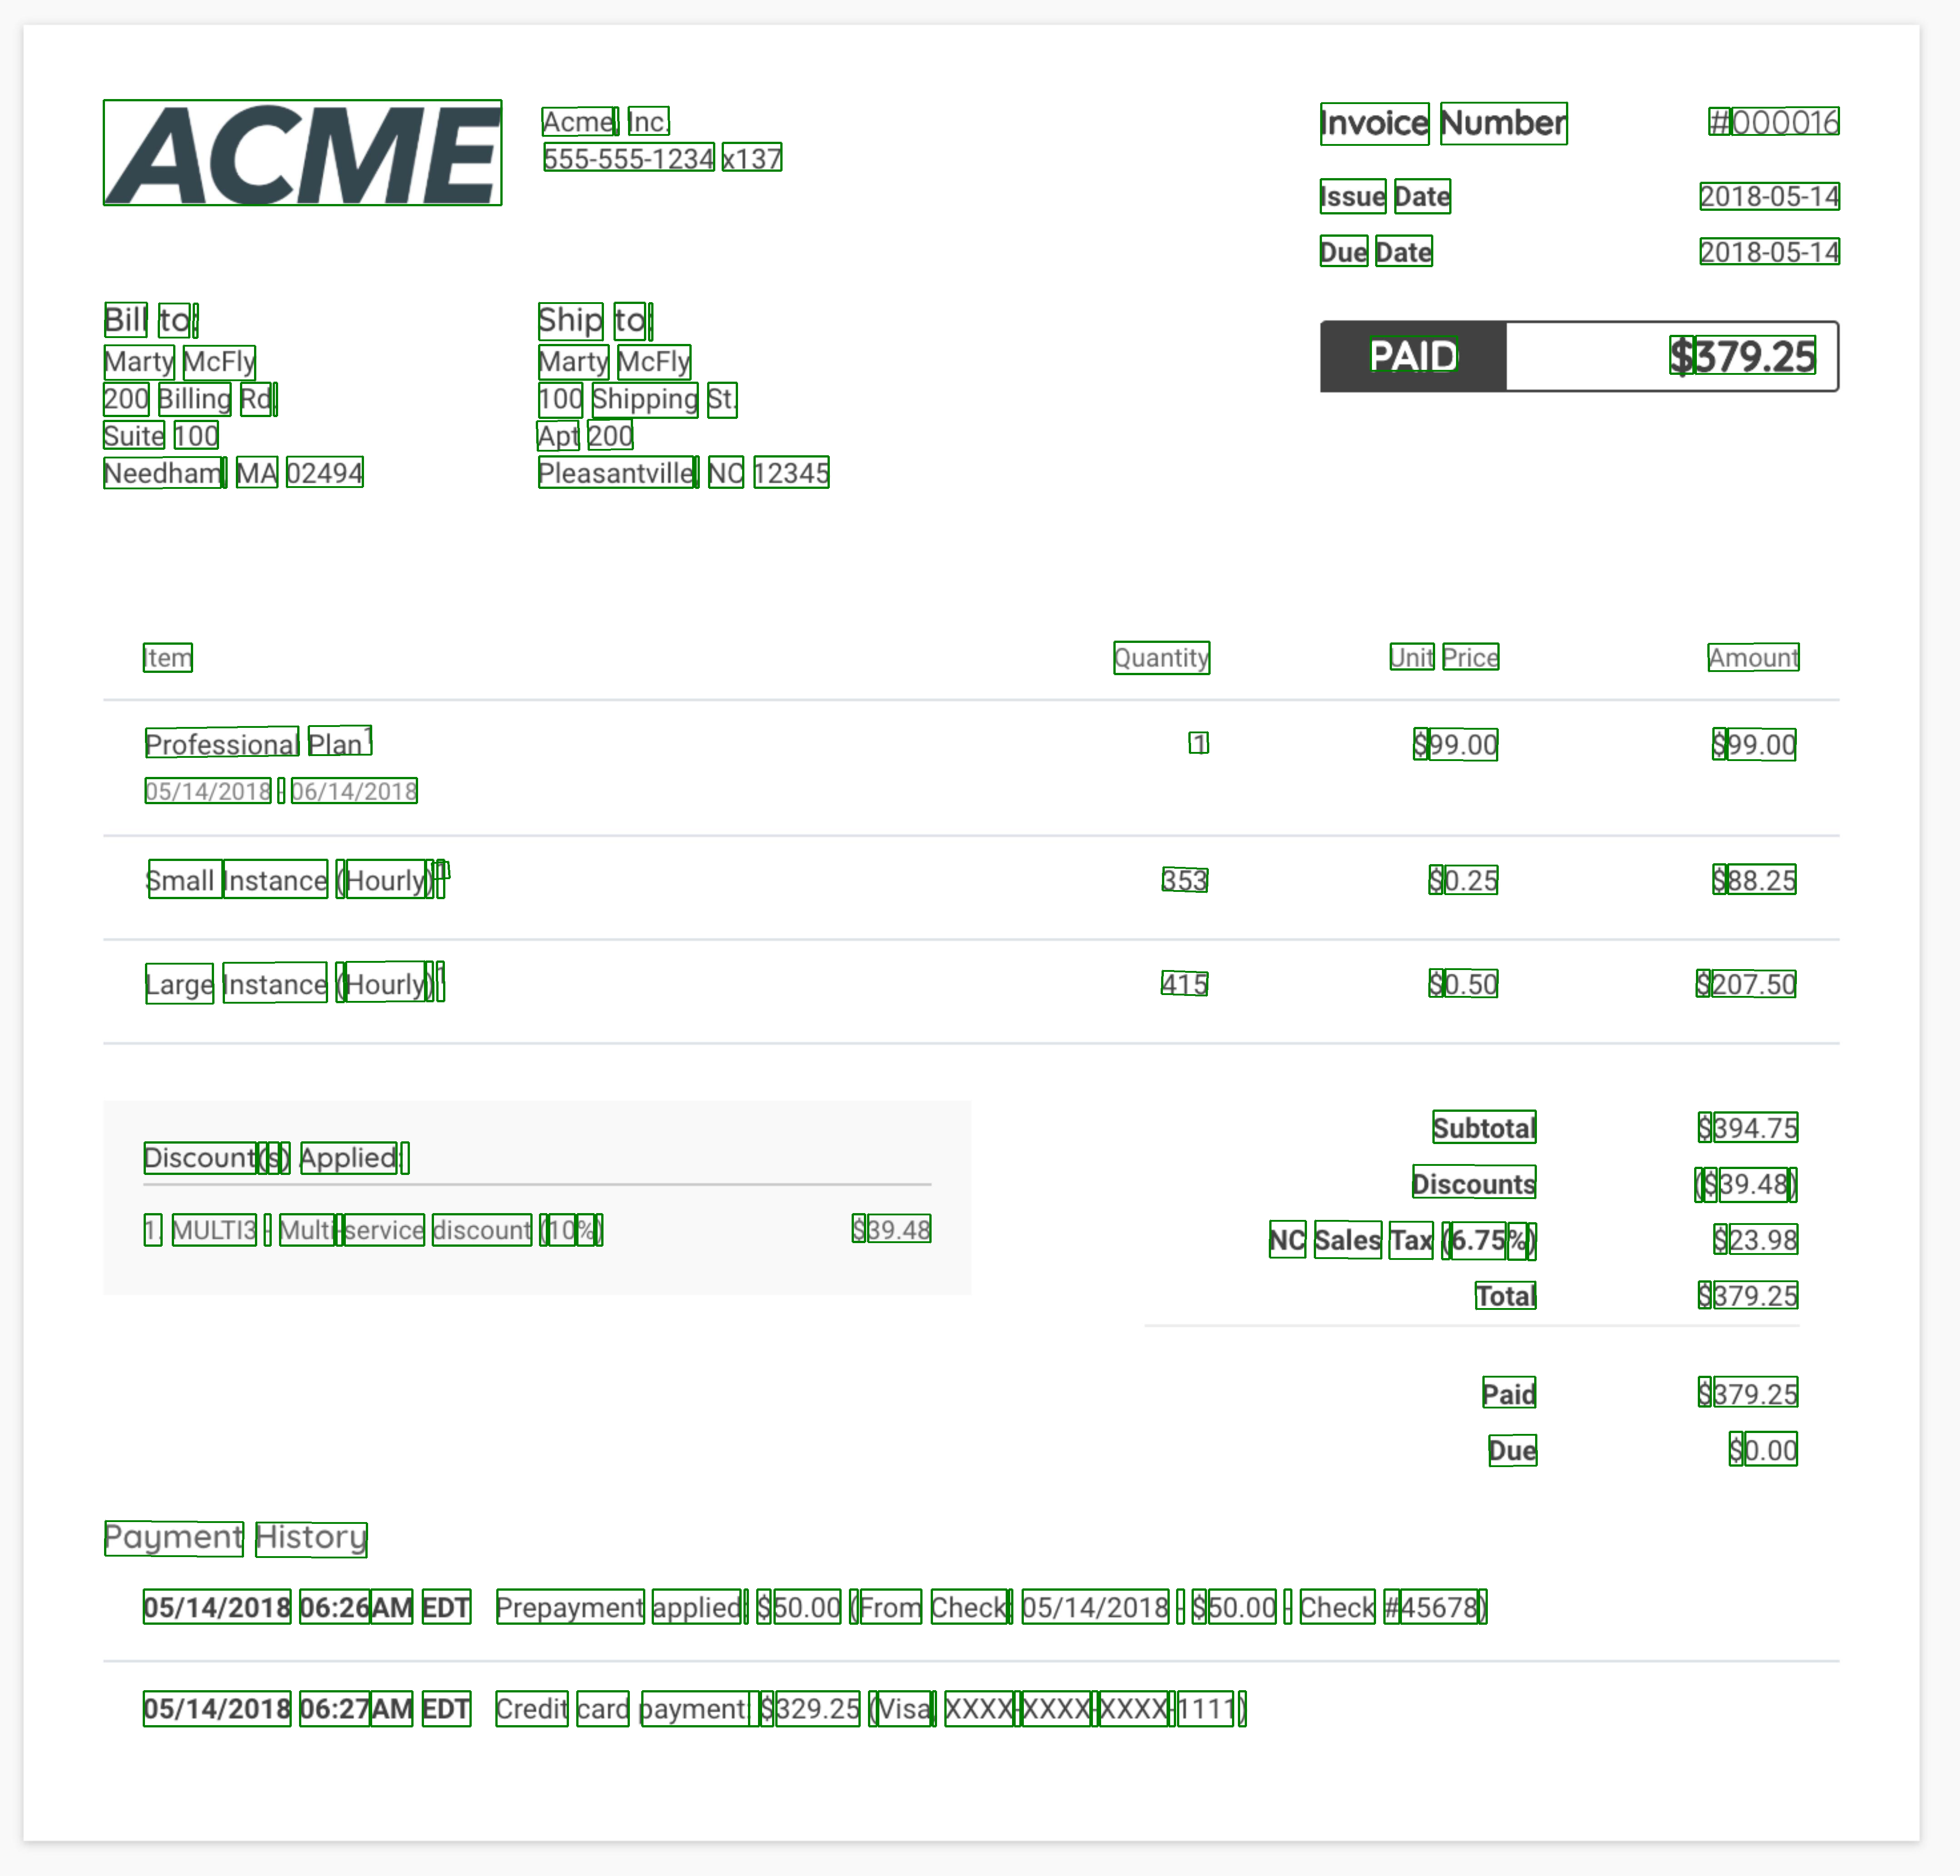

In [18]:
#For text
bounds = get_document_bounds(response, FeatureType.WORD)
draw_boxes(image, bounds, 'green')

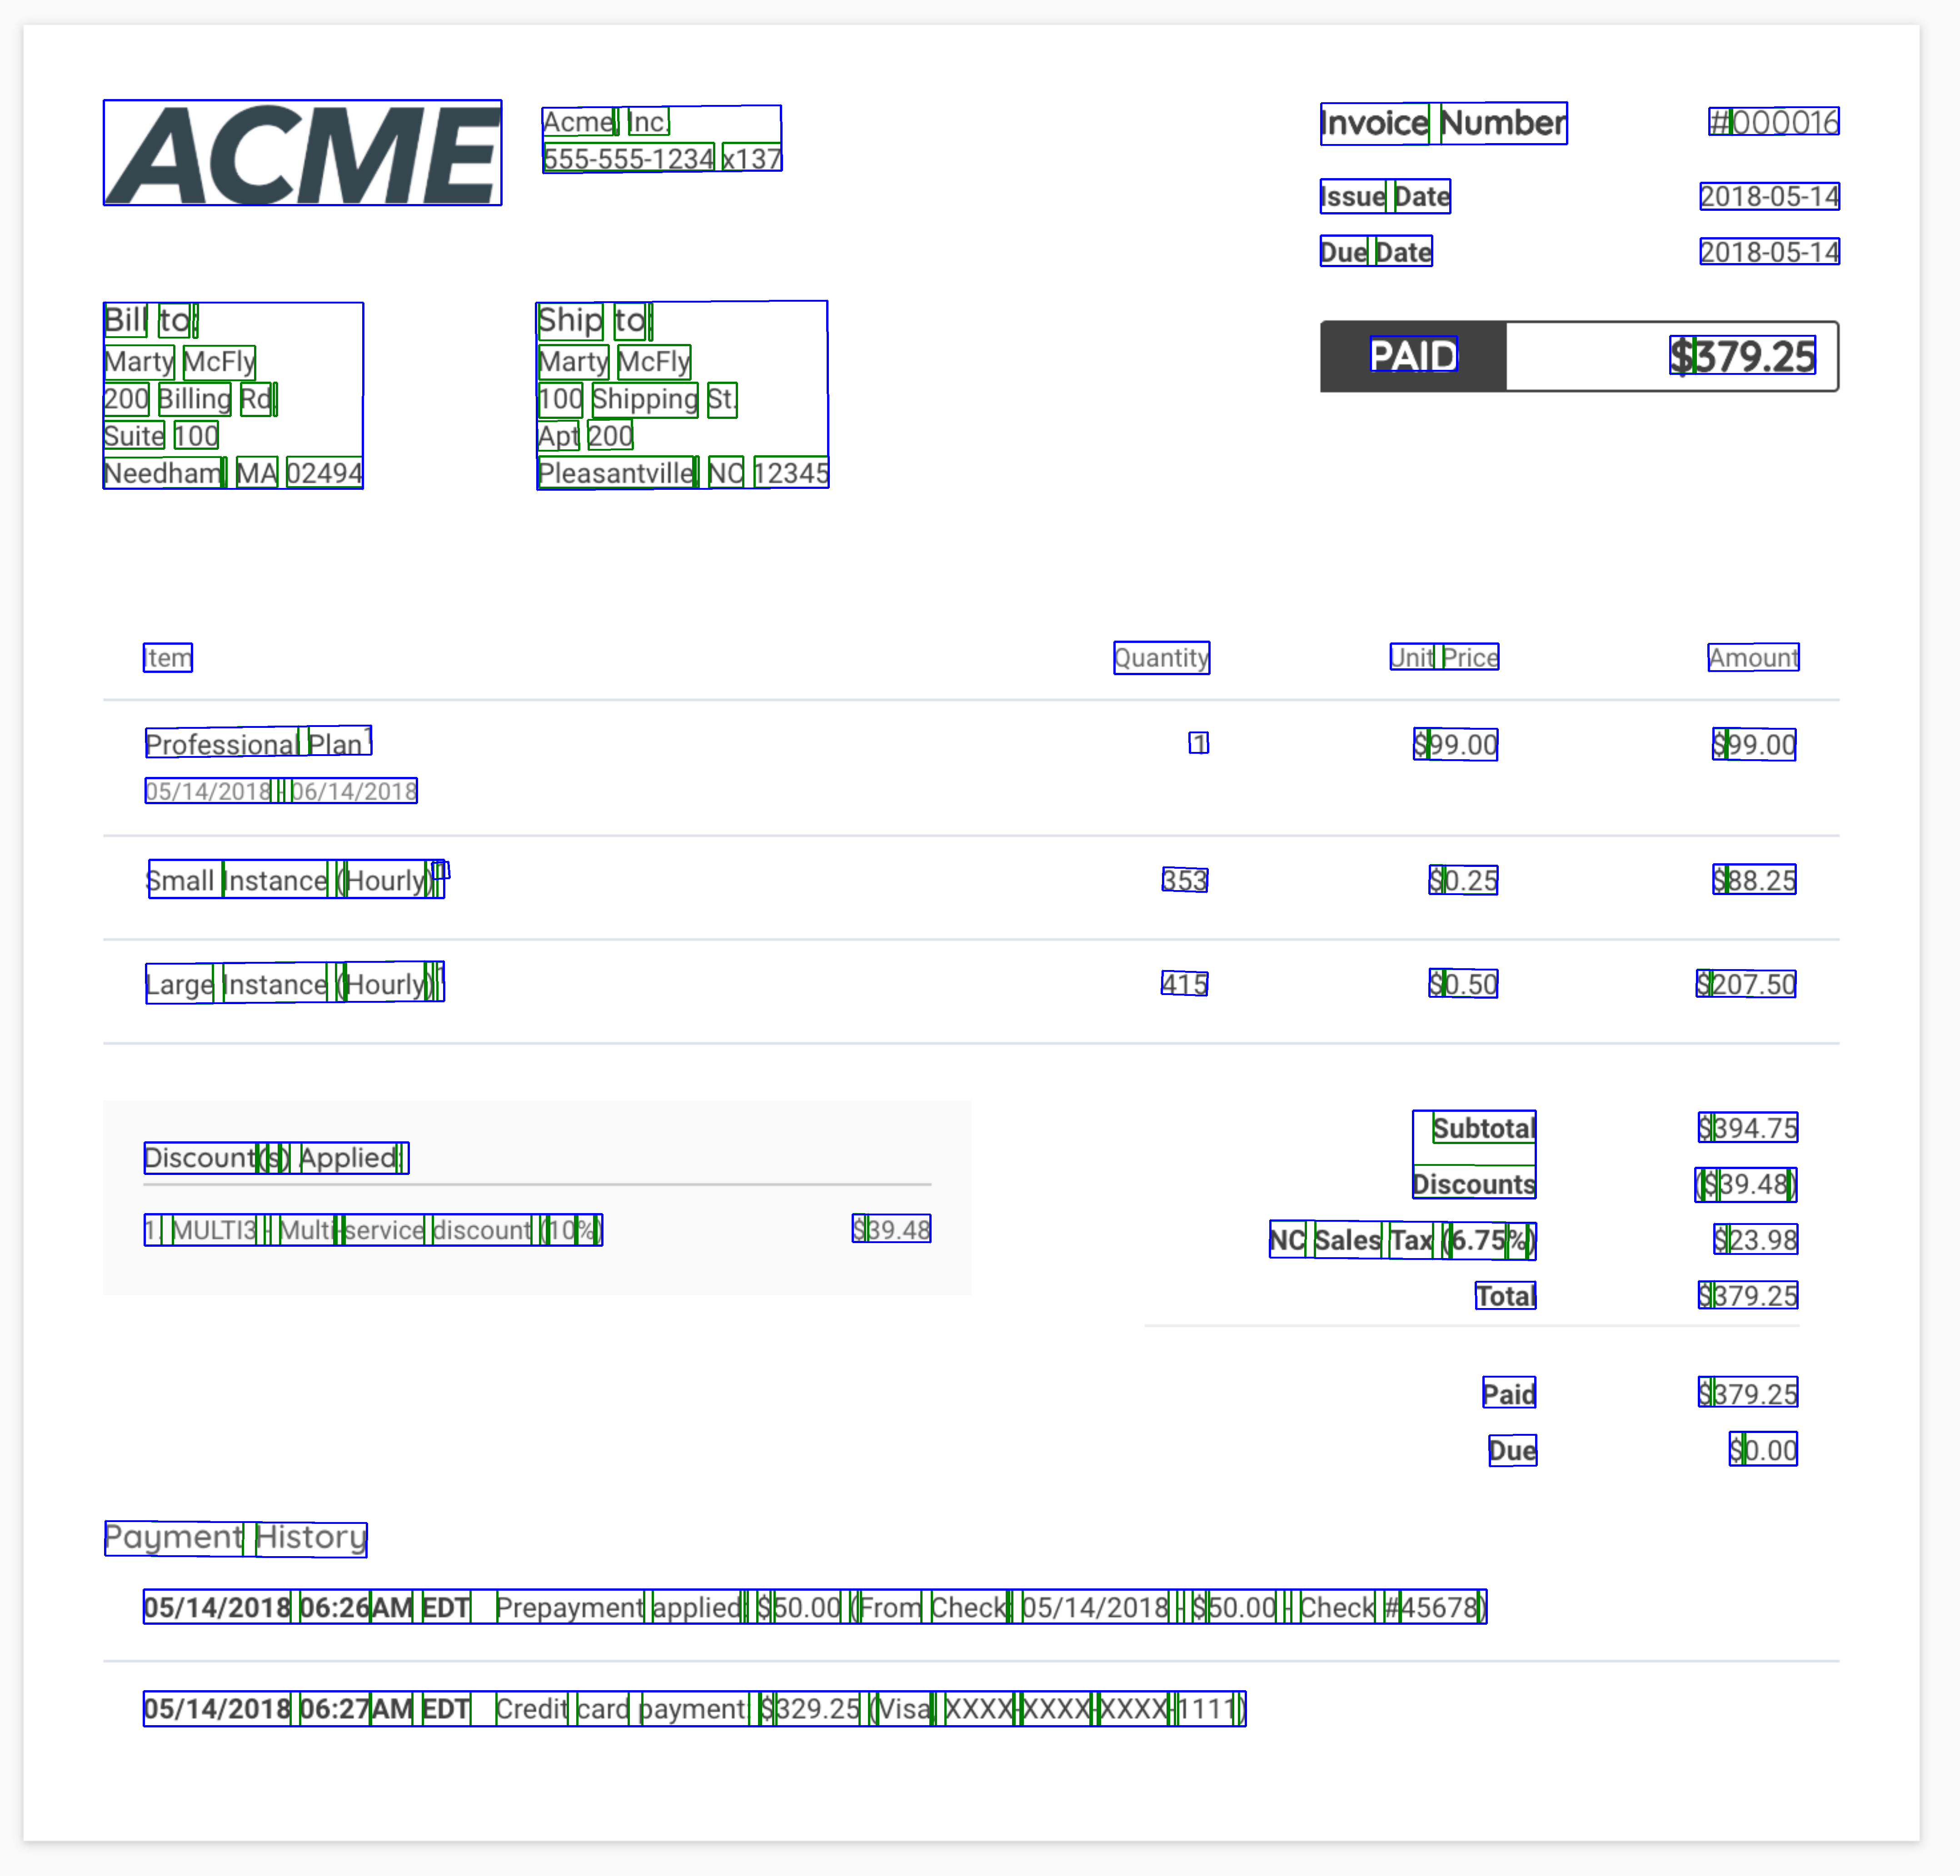

In [19]:
#For blocks
blocks = get_document_bounds(response, FeatureType.BLOCK)
draw_boxes(image, blocks, '#0000FF')

### Confidence Levels

In [20]:
# #to extract confidence levels 
# document = response.full_text_annotation
# print(document)

In [48]:
def get_document_confidence(response, feature):
    confidence=[]
    for i,page in enumerate(document.pages):
        for block in page.blocks:
            if feature == FeatureType.BLOCK:
                confidence.append(block.confidence)
            for paragraph in block.paragraphs:
                if feature == FeatureType.PARA:
                    confidence.append(paragraph.confidence)
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            confidence.append(symbol.confidence)
                    if (feature == FeatureType.WORD):
                        confidence.append(word.confidence)
    return confidence

In [49]:
confidence = get_document_confidence(response, FeatureType.WORD)
average = sum(confidence)/len(confidence)
average

0.9730113729072566

### Levenshtein Distance Score

In [11]:
lev_distance(invoice_txt, gvision_txt)

0

### Key word pairings

In [12]:
# Number of key edits required for key word pairings to be correct
google_key = str_distance(gvision_txt, keywords)
print(google_key - base_key)

0


## Micosoft Azure Cloud Vision

In [54]:
vision_base_url = "https://westcentralus.api.cognitive.microsoft.com/vision/v2.0/"
ocr_url = vision_base_url + "ocr"

In [55]:
credential = DefaultAzureCredential()
form_recognizer_client = FormRecognizerClient(
    endpoint = "https://<my-custom-subdomain>.cognitiveservices.azure.com/",
    credential = credential
)

In [56]:
subscription_key = '0412d1c4518947eab453385bd954af49'
assert subscription_key

In [57]:
image_url = '__'

In [58]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key}
params   = {'language': 'unk', 'detectOrientation ': 'true', 'confidence':'true'}
data     = {'url': image_url}


response = requests.post(ocr_url, headers=headers, params=params, json=data)
response.raise_for_status()

analysis = response.json()

In [59]:
line_infos = [region["lines"] for region in analysis["regions"]]
word_infos = []
for line in line_infos:
    for word_metadata in line:
        for word_info in word_metadata["words"]:
            word_infos.append(word_info)

### Text Extraction

In [60]:
for word in word_infos:
    text = word["text"]
    sys.stdout.write(text + ' ')

ACME Bill to: Marty McFly 200 Billing Rd. Suite 100 Needham, MA 02494 Item Professional plan I 05/14/2018- 06/14/2018 Small Instance (Hourly)l Large Instance (Hourly)l Discount(s) Applied: Acme, Inc. 555-555-1234 n 37 Ship to: Marty McFly 100 Shipping St. Apt 200 Pleasantville, NC 12345 Quantity 353 415 1. MULT13 - Multi-service discount (10%) Payment History $39.48 Invoice Number Issue Date Due Date PAID Unit price $99.00 $0.25 $0.50 Subtotal Discounts NC Sales Tax (6.75%) Total paid #000016 2018-05-14 2018-05-14 $379.25 Amount $99.00 $88.25 $207.50 $394.75 ($39.48) $23.98 $379.25 $379.25 $0.00 05/14/2018 06:26AM EDT prepayment applied: $50.00 (From Check: 05/14/2018 • $50.00. Check #45678) 

In [67]:
azure_txt = "ACME Bill to: Marty McFly 200 Billing Rd. Suite 100 Needham, MA 02494 Item Professional plan I 05/14/2018- 06/14/2018 Small Instance (Hourly)l Large Instance (Hourly)l Discount(s) Applied: Acme, Inc. 555-555-1234 n 37 Ship to: Marty McFly 100 Shipping St. Apt 200 Pleasantville, NC 12345 Quantity 353 415 1. MULT13 - Multi-service discount (10%) Payment History $39.48 Invoice Number Issue Date Due Date PAID Unit price $99.00 $0.25 $0.50 Subtotal Discounts NC Sales Tax (6.75%) Total paid #000016 2018-05-14 2018-05-14 $379.25 Amount $99.00 $88.25 $207.50 $394.75 ($39.48) $23.98 $379.25 $379.25 $0.00 05/14/2018 06:26AM EDT prepayment applied: $50.00 (From Check: 05/14/2018 • $50.00. Check #45678)"

### Plotting bounding boxes 

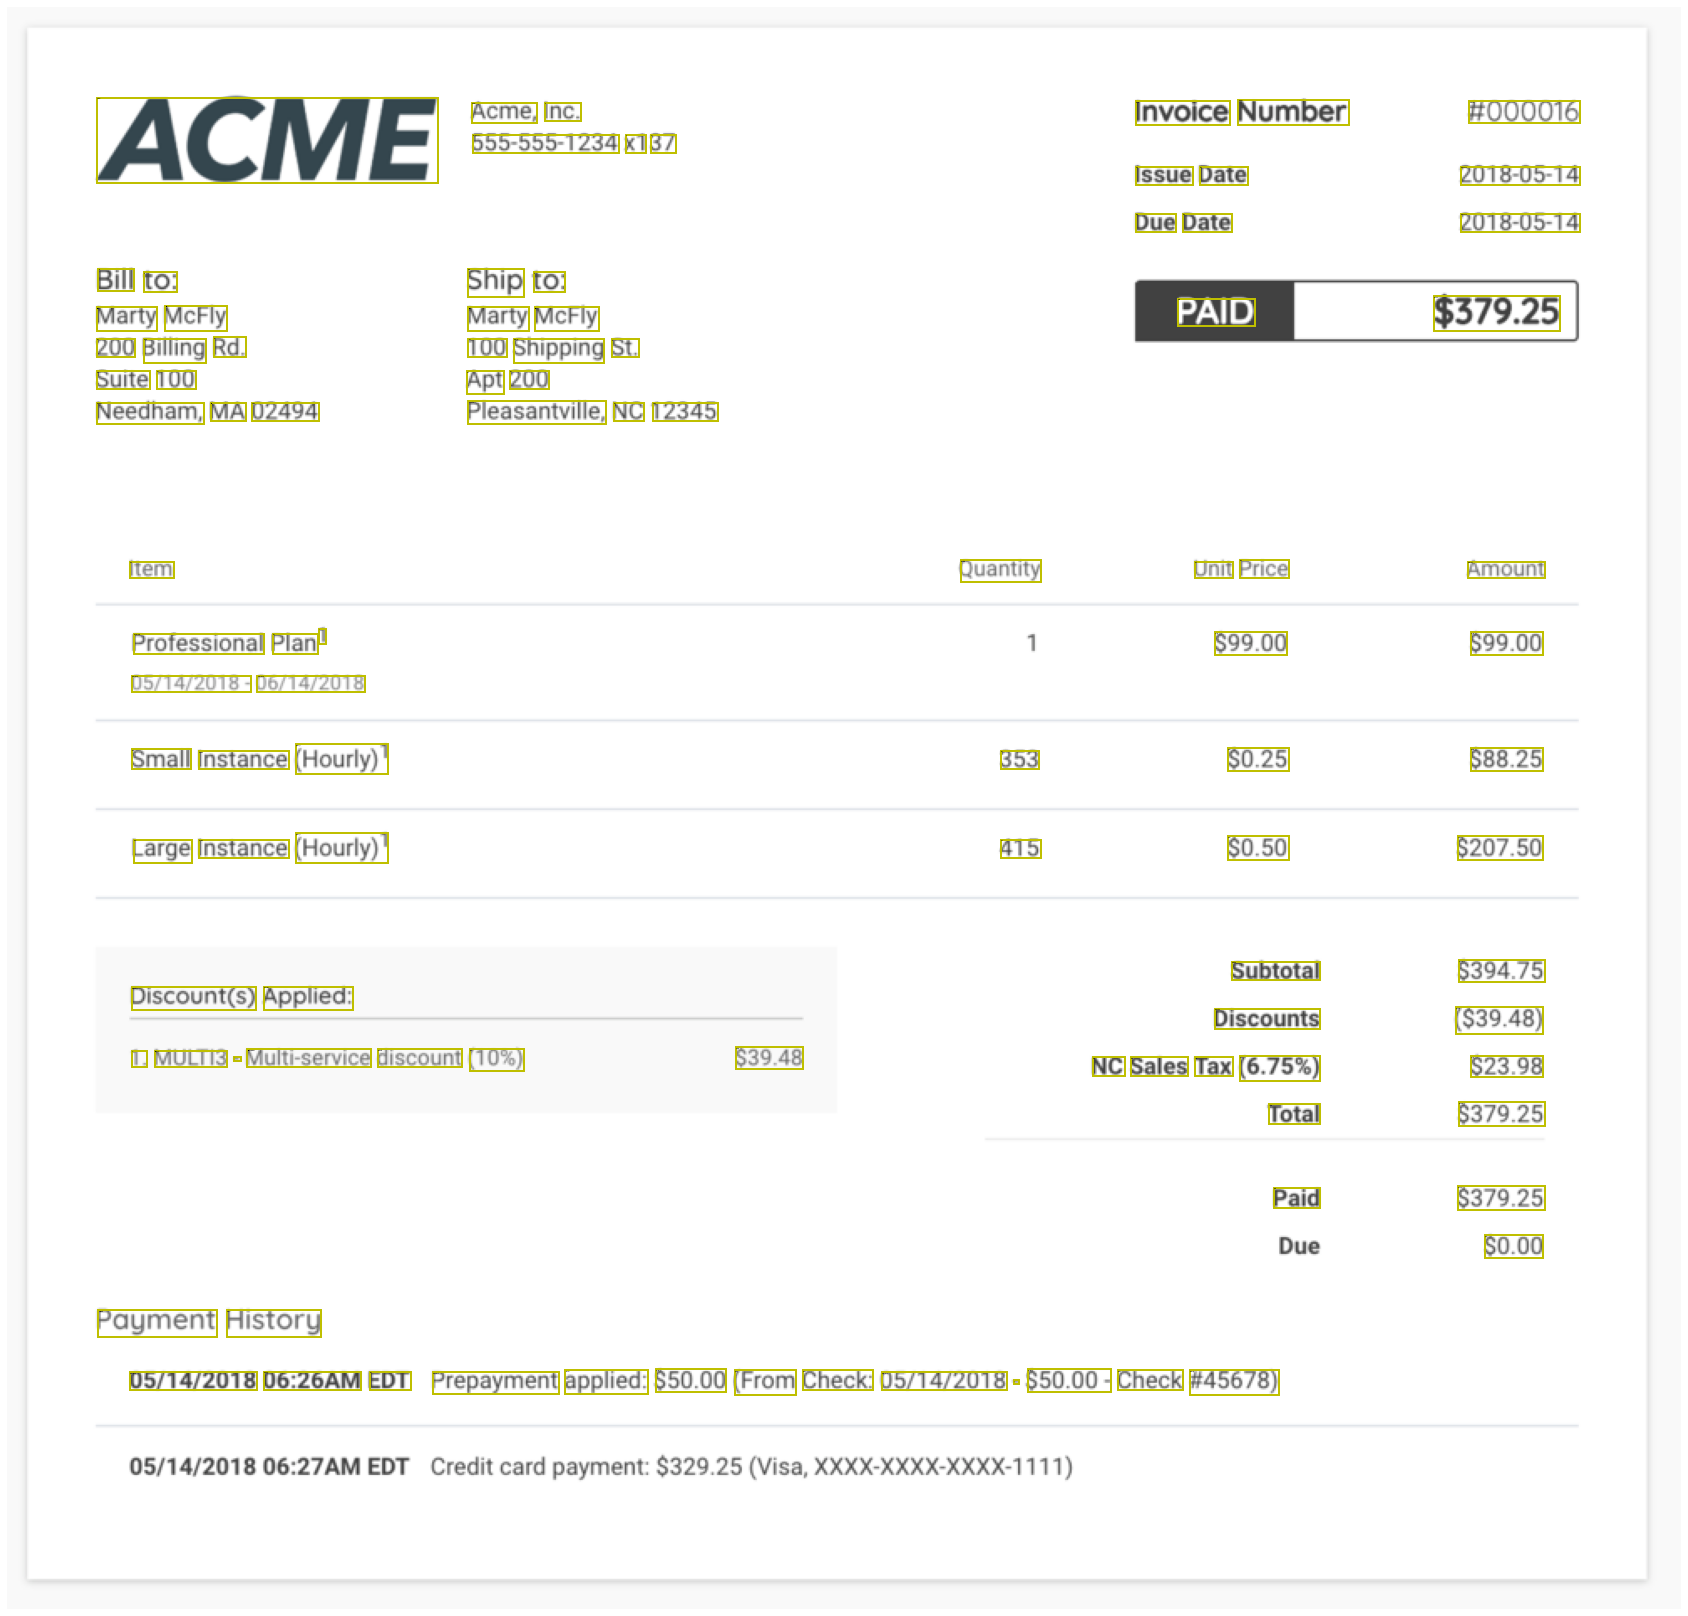

In [62]:
plt.figure(figsize=(30, 30))


image  = Image.open(BytesIO(requests.get(image_url).content))
ax     = plt.imshow(image)
for word in word_infos:
    bbox = [int(num) for num in word["boundingBox"].split(",")]
    text = word["text"]
    origin = (bbox[0], bbox[1])
    patch  = Rectangle(origin, bbox[2], bbox[3], fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(origin[0], origin[1], text, fontsize=0, weight="bold", va="top")
_ = plt.axis("off")

### Confidence Levels

In [63]:
endpoint = "https://centralus.api.cognitive.microsoft.com/"
credential = AzureKeyCredential("credential")
form_recognizer_client = FormRecognizerClient(endpoint, credential)

# invoice = 'invoices/invoice2.pdf'
pages = convert_from_path(invoice, 501)

for page in pages:
    page.save('tmp.jpg')
    with io.open('tmp.jpg', 'rb') as image_file:
        content = image_file.read()
    os.system('rm tmp.jpg')

poller = form_recognizer_client.begin_recognize_content(content)
page = poller.result()

In [64]:
for i in range(30):
    print(page[0].lines[i + 1])

FormLine(text=Acme, Inc., bounding_box=[Point(x=1193.0, y=242.0), Point(x=1477.0, y=243.0), Point(x=1477.0, y=297.0), Point(x=1193.0, y=296.0)], words=[FormWord(text=Acme,, bounding_box=[Point(x=1195.0, y=242.0), Point(x=1366.0, y=243.0), Point(x=1365.0, y=297.0), Point(x=1196.0, y=298.0)], confidence=0.958, page_number=1), FormWord(text=Inc., bounding_box=[Point(x=1377.0, y=243.0), Point(x=1477.0, y=244.0), Point(x=1475.0, y=298.0), Point(x=1376.0, y=297.0)], confidence=0.82, page_number=1)], page_number=1)
FormLine(text=Invoice Number, bounding_box=[Point(x=2904.0, y=235.0), Point(x=3454.0, y=235.0), Point(x=3454.0, y=306.0), Point(x=2904.0, y=305.0)], words=[FormWord(text=Invoice, bounding_box=[Point(x=2905.0, y=238.0), Point(x=3150.0, y=235.0), Point(x=3150.0, y=306.0), Point(x=2904.0, y=304.0)], confidence=0.949, page_number=1), FormWord(text=Number, bounding_box=[Point(x=3168.0, y=235.0), Point(x=3452.0, y=237.0), Point(x=3452.0, y=307.0), Point(x=3167.0, y=306.0)], confidence=0.

In [66]:
azure_confidence = (0.958,0.82,0.949,0.959,0.959,0.945,0.95,0.799,0.959,0.935,0.849,0.959,0.959,0.959,0.957,0.959,0.954,0.959,0.958,0.959,0.958,0.959,0.959,0.952,0.958,0.949,0.957,0.958,0.958,0.958,0.959,0.915,0.958,0.958,0.958,0.958,0.958,0.913,0.949,0.959,0.687,0.959,0.959,0.959,0.959,0.958,0.799,0.916,0.923,0.94,0.868,0.958,0.958,0.94,0.946,0.799,0.958)
azure_average = sum(azure_confidence)/len(azure_confidence)

azure_average

0.934070175438596

### Levenshtein Distance Score

In [68]:
lev_distance(invoice_txt, azure_txt)

1101

### Key word pairings

In [69]:
# Number of key edits required for key word pairings to be correct
azure_key = str_distance(azure_txt, keywords)
print(base_key - azure_key)

89
